In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid

from src.model.sampling import *
from src.utils import scaled_mcc, NpEncoder
from src.model.dkdn import DkDN

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
data = pd.read_parquet(f'../data/appendicitis.parquet')

In [4]:
# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=['y']))
y = data.y.values

y[y == -1] = 0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

mask_class_0 = y_train == 0
mask_class_1 = y_train == 1

dynamic_kdn = DkDN(k=3)
dynamic_kdn.fit(X_train, y_train)
complexity_d = dynamic_kdn.complexity
complexity_d_global = np.mean(complexity_d)
complexity_d_class_0 = np.mean(complexity_d[mask_class_0])
complexity_d_class_1 = np.mean(complexity_d[mask_class_1])

In [38]:
rng_seed = 1234

cuts = [round(i*0.01, 2) for i in range(5, 100, 5)]
complexity_grouped = complexity_grouping(complexity_d, cuts)
rng_cuts = [[0.05, 0.10, 0.15, 0.20, 0.25], [0.30, 0.40, 0.45], [0.50, 0.60, 0.70, 0.75], [0.80, 0.85], [0.90, 0.95]]
rng = np.random.default_rng(rng_seed)
smpl_cuts = [rng.choice(i) for i in rng_cuts]
samples_filtered = filter_sampling(complexity_grouped, cuts=smpl_cuts, p=1, random_state=1234)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

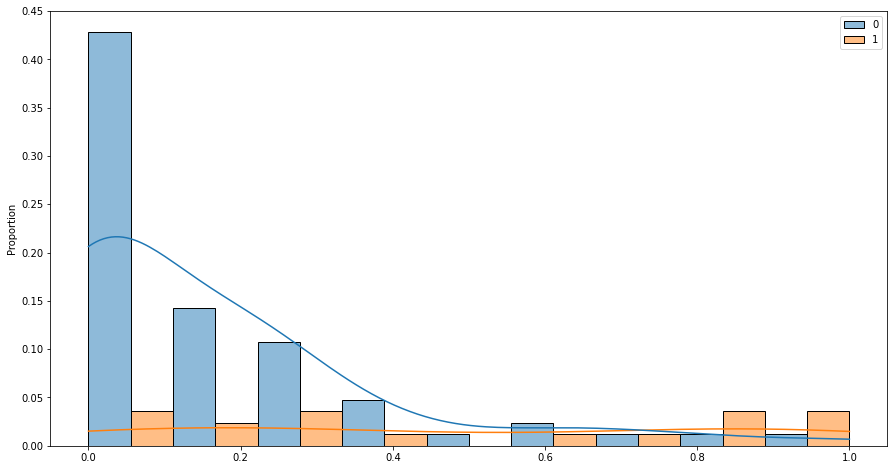

In [40]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity_d, hue=y_train.astype(int), kde=True, multiple='dodge', stat='proportion');

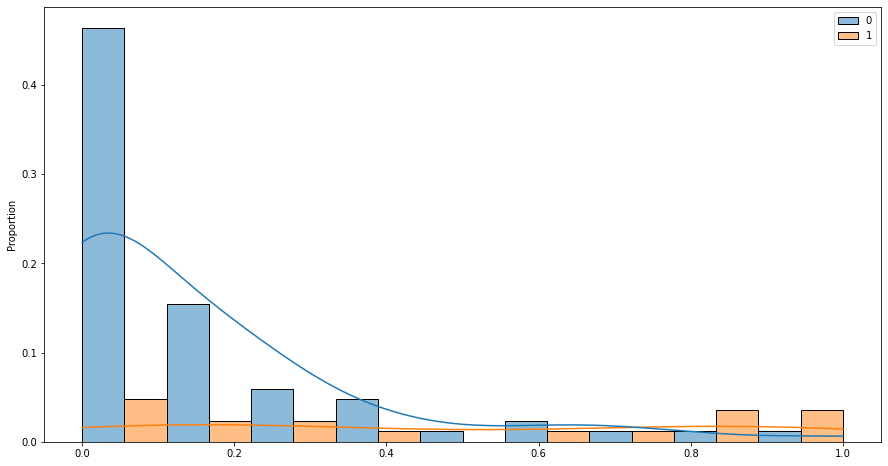

In [41]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity_grouped, hue=y_train.astype(int), kde=True, multiple='dodge', stat='proportion');

In [164]:
samples_scores = np.full(len(cuts), 0.0)
samples_scores

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [165]:
samples_params = np.full(len(cuts), None)
samples_params

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None], dtype=object)

In [166]:
smpl_idx = [cuts.index(i) for i in smpl_cuts]

In [167]:
smpl_idx

[4, 8, 14, 15, 17]

In [168]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng_seed)

methods = [[KNeighborsClassifier, {'n_neighbors' : list(range(1, 13, 2)), 'n_jobs': [-1]}]]

for method, grid_params in methods:
    
    for i, complexity_index in list(zip(smpl_idx, samples_filtered)):
        
        best_score = 0
        best_params = None
        
        for params in list(ParameterGrid(grid_params)):
            
            clf = method(**params)
            scores = []
            
            for train_index, test_index in skf.split(X_train, y_train):
                
                try:
                    sample_index = list(set(train_index).intersection(complexity_index))
                    clf.fit(X_train[sample_index], y_train[sample_index])
                    preds = clf.predict(X_train[test_index])
                    scoring = scaled_mcc(y_train[test_index], preds)
                except:
                    scoring = 0
                scores.extend([scoring])
                
            if np.mean(scores) > best_score:
                best_score = np.mean(scores)
                best_params = params
                
        samples_scores[i] = best_score
        samples_params[i] = best_params

# pensar cómo se buscan los dos más próximos y sobre todo cómo comprobar que no existen ya

    # clf = method(**best_params)
    # clf.fit(X_train[complexity_index], y_train[complexity_index])
    # preds_test = clf.predict(X_test)
    # score_test = scaled_mcc(y_test, preds_test)

In [169]:
samples_scores

array([0.        , 0.        , 0.        , 0.        , 0.77944897,
       0.        , 0.        , 0.        , 0.77944897, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.77944897,
       0.78457557, 0.        , 0.77944897, 0.        ])

In [170]:
samples_params

array([None, None, None, None, {'n_jobs': -1, 'n_neighbors': 1}, None,
       None, None, {'n_jobs': -1, 'n_neighbors': 1}, None, None, None,
       None, None, {'n_jobs': -1, 'n_neighbors': 3},
       {'n_jobs': -1, 'n_neighbors': 1}, None,
       {'n_jobs': -1, 'n_neighbors': 7}, None], dtype=object)

In [171]:
np.nanargmax(samples_scores)

15

In [175]:
np.where(np.max(samples_scores)-np.array(samples_scores)<10e-4)[0]

array([15])